# Time Series - LinearRegression and Trend


In [55]:
# Linear Regression with Time Series

In [56]:
# Forecasting is perhaps the most common application of machine learning in the real world. 
# Businesses forecast product demand, governments forecast economic and population growth, meteorologists forecast the weather. 
# Linear Regression : target = weight_1 * feature_1 + weight_2 * feature_2 + bias

In [57]:
# Setup notebook
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

data_dir = Path('./inputKaggle/TSCourseData/')
comp_dir = Path('./inputKaggle/StoredSales/')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

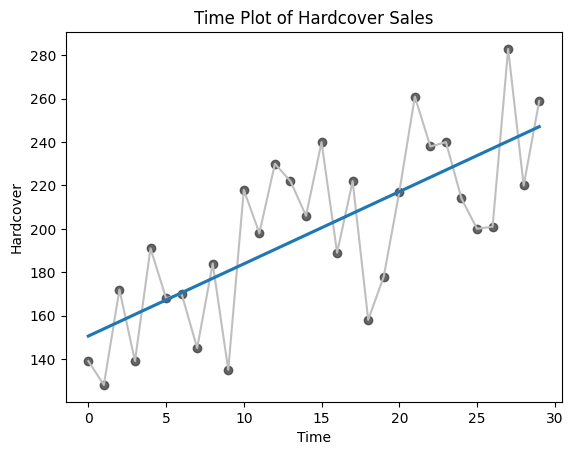

In [58]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

In [59]:
#Interpret linear regression with the time dummy
#The linear regression line has an equation of (approximately) Hardcover = 3.33 * Time + 150.5. Over 6 days how much on average would you expect hardcover sales to change?
#A change of 6 steps in Time corresponds to an average change of 6 * 3.33 = 19.98 in Hardcover sales.

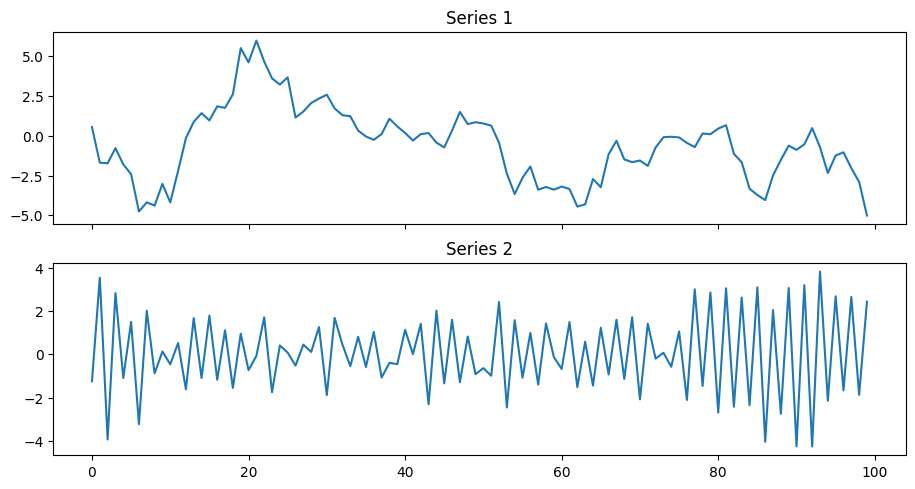

In [60]:
#Interpret linear regression with a lag feature
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

In [61]:
#One of these series has the equation `target = 0.95 * lag_1 + error` and the other has the equation `target = -0.95 * lag_1 + error`, 
# differing only by the sign on the lag feature. Can you tell which equation goes with each series?
# Series 1 was generated by target = 0.95 * lag_1 + error and Series 2 was generated by target = -0.95 * lag_1 + error.

In [62]:
#Fit a time-step feature
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index))  # time dummy

df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)



In [63]:
#ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [64]:
# Fit a lag feature to Store Sales
df = average_sales.to_frame()

lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1

X = df.loc[:, ['lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'sales']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

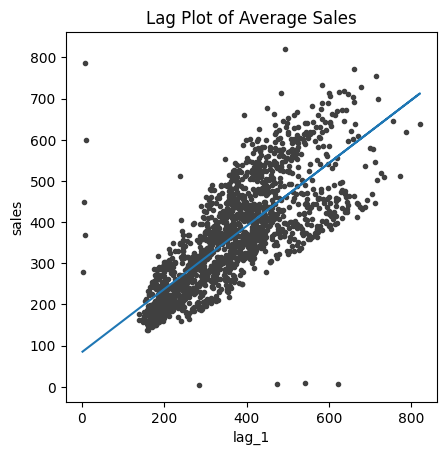

In [65]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

In [66]:
# Trend

In [67]:
import pandas as pd
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

data_dir = Path('./inputKaggle/TSCourseData/')
comp_dir = Path('./inputKaggle/StoredSales/')

retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [ ]:
#ax = food_sales.plot(kind=[1, 2, 3, 4])
#ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

In [ ]:
# Add methods to `food_sales` to compute a moving
# average with appropriate parameters for trend estimation.
trend = food_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

# Make a plot
#ax = food_sales.plot(**plot_params, alpha=0.5)
#ax = trend.plot(ax=ax, linewidth=3)

In [ ]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

#ax = average_sales.plot(**plot_params, alpha=0.5)
#ax = trend.plot(ax=ax, linewidth=3)

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()

dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

In [ ]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
#ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
#ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
#ax.legend();

In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

#ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
#ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
#ax.legend();

In [ ]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

#ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
#ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
#ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
#ax.legend();